# **RNN - MODELS : Deteksi Sarkasme**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from keras_tuner import Hyperband
import pandas as pd
import json
import seaborn as sns

In [4]:
# Load the JSON file
with open('DeteksiSarkasme.json', 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

In [5]:
# Display a sample from the dataset
print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Encoding the target labels
encoder = LabelEncoder()
df['is_sarcastic'] = encoder.fit_transform(df['is_sarcastic'])

In [7]:
# Split the data into training and testing sets
X = df['headline'].values
y = df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Preprocess the text data using TensorFlow tokenizer
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [11]:
# Define the RNN model in PyTorch
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        rnn_out = rnn_out[:, -1, :]
        x = self.fc(rnn_out)
        return self.sigmoid(x)

In [12]:
# PyTorch Model Training Function with accuracy and loss tracking
def train_pytorch_model(model, criterion, optimizer, train_data, train_labels, val_data, val_labels, num_epochs=5, batch_size=64):
    model.train()

    # Lists to store loss and accuracy for visualization
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0

        # Training loop
        for i in range(0, len(train_data), batch_size):
            inputs = torch.tensor(train_data[i:i+batch_size]).long()
            labels = torch.tensor(train_labels[i:i+batch_size]).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        # Calculate average loss and accuracy for this epoch
        avg_loss = epoch_loss / (len(train_data) // batch_size)
        accuracy = correct_predictions / total_predictions * 100

        # Append loss and accuracy for training
        train_loss_list.append(avg_loss)
        train_accuracy_list.append(accuracy)

        # Validation loop
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            val_loss = 0
            correct_predictions = 0
            total_predictions = 0
            for i in range(0, len(val_data), batch_size):
                inputs = torch.tensor(val_data[i:i+batch_size]).long()
                labels = torch.tensor(val_labels[i:i+batch_size]).float().view(-1, 1)
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

            avg_val_loss = val_loss / (len(val_data) // batch_size)
            val_accuracy = correct_predictions / total_predictions * 100

            # Append loss and accuracy for validation
            val_loss_list.append(avg_val_loss)
            val_accuracy_list.append(val_accuracy)

        # Print stats for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [13]:
# Set up the PyTorch model
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 1
model_pytorch = RNNModel(input_dim, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

In [14]:
# Train the PyTorch model and get the loss and accuracy for each epoch
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train_pytorch_model(
    model_pytorch, criterion, optimizer, X_train_pad, y_train, X_test_pad, y_test, num_epochs=5)

Epoch 1/5, Train Loss: 0.5858, Train Accuracy: 68.12%, Val Loss: 0.5076, Val Accuracy: 75.57%
Epoch 2/5, Train Loss: 0.4335, Train Accuracy: 80.42%, Val Loss: 0.4375, Val Accuracy: 80.04%
Epoch 3/5, Train Loss: 0.3318, Train Accuracy: 86.08%, Val Loss: 0.4165, Val Accuracy: 81.15%
Epoch 4/5, Train Loss: 0.2574, Train Accuracy: 90.14%, Val Loss: 0.4263, Val Accuracy: 81.39%
Epoch 5/5, Train Loss: 0.2039, Train Accuracy: 92.55%, Val Loss: 0.4533, Val Accuracy: 82.46%


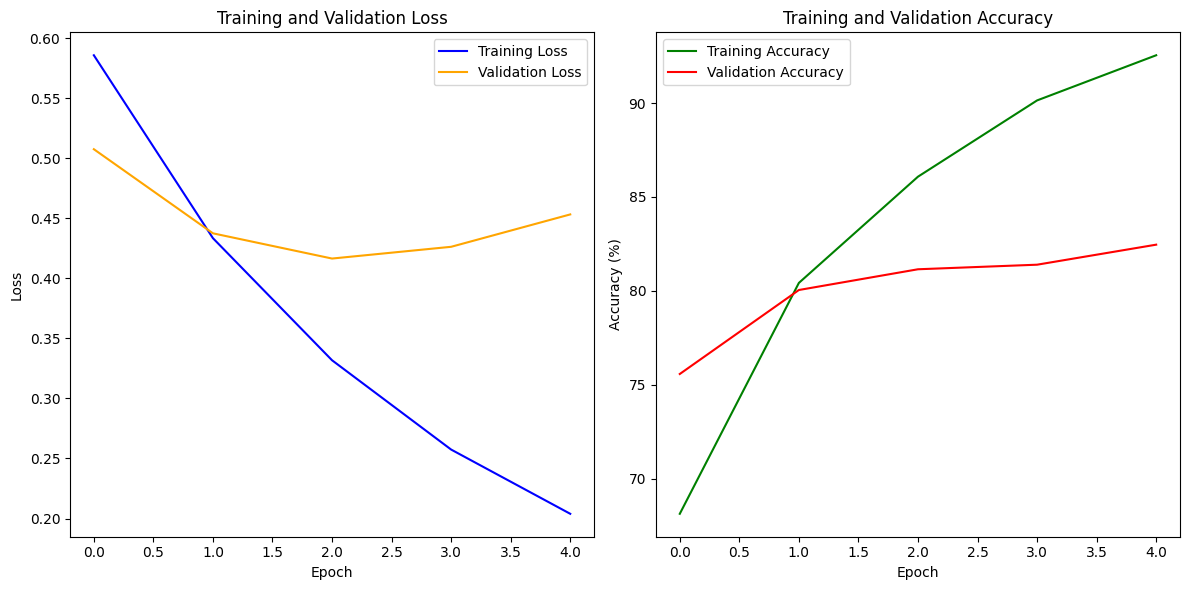

In [15]:
# Plot the loss and accuracy curves for PyTorch with validation
def plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy', color='green')
    plt.plot(val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function for PyTorch
plot_metrics(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [16]:
# Evaluate the PyTorch model
model_pytorch.eval()
y_pred_pytorch = model_pytorch(torch.tensor(X_test_pad).long()).detach().numpy()
y_pred_pytorch = (y_pred_pytorch > 0.5).astype(int)

# Metrics Calculation for PyTorch
print("PyTorch Accuracy:", accuracy_score(y_test, y_pred_pytorch))
print("PyTorch Precision:", precision_score(y_test, y_pred_pytorch))
print("PyTorch Recall:", recall_score(y_test, y_pred_pytorch))
print("PyTorch F1 Score:", f1_score(y_test, y_pred_pytorch))
print("PyTorch AUC:", roc_auc_score(y_test, y_pred_pytorch))

PyTorch Accuracy: 0.8245975290153501
PyTorch Precision: 0.8510214250124564
PyTorch Recall: 0.7280477408354646
PyTorch F1 Score: 0.784746152079026
PyTorch AUC: 0.8141240039290808


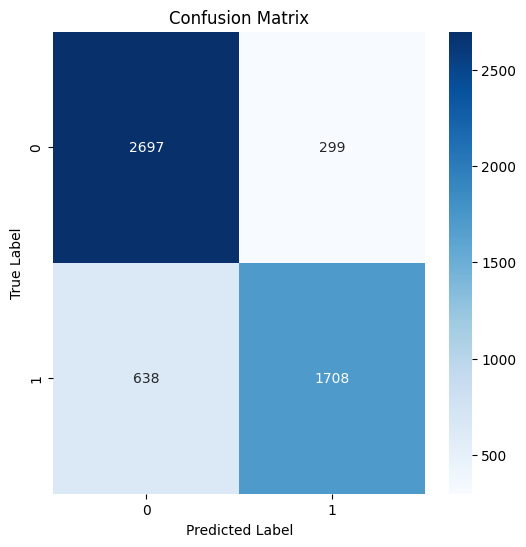

Classification Report for PyTorch:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      2996
           1       0.85      0.73      0.78      2346

    accuracy                           0.82      5342
   macro avg       0.83      0.81      0.82      5342
weighted avg       0.83      0.82      0.82      5342



In [17]:
# Confusion Matrix and Classification Report for PyTorch
cm = confusion_matrix(y_test, y_pred_pytorch)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_pytorch)
print("Classification Report for PyTorch:\n", report)

In [18]:
# TensorFlow RNN Model
def create_rnn_model(input_dim, embedding_dim, hidden_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, embedding_dim, input_length=max_len),
        tf.keras.layers.SimpleRNN(hidden_dim),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
# Hyperparameter Tuning with Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, hp.Int('embedding_dim', min_value=50, max_value=200, step=50), input_length=max_len),
        tf.keras.layers.SimpleRNN(hp.Int('rnn_units', min_value=50, max_value=200, step=50)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
# Initialize Hyperband tuner
tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='sarcasm_detection')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Fit the model using Hyperband
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))

Trial 9 Complete [00h 02m 15s]
val_accuracy: 0.8386372327804565

Best val_accuracy So Far: 0.8401347994804382
Total elapsed time: 00h 20m 09s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
150               |50                |embedding_dim
100               |100               |rnn_units
0.00073306        |0.00010095        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
203/668 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.6004 - loss: 0.6522

KeyboardInterrupt: 

In [22]:
# Get the best model from Hyperband
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Display the summary of the best model (TensorFlow)
print("Best Model Summary:")
best_model.summary()  # Display model architecture and params

Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │     1,326,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,001 (5.12 MB)

 Trainable params: 1,342,001 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Evaluate the TensorFlow model
y_pred_tensorflow = best_model.predict(X_test_pad)
y_pred_tensorflow = (y_pred_tensorflow > 0.5).astype(int)

# Metrics Calculation for TensorFlow
print("TensorFlow Accuracy:", accuracy_score(y_test, y_pred_tensorflow))
print("TensorFlow Precision:", precision_score(y_test, y_pred_tensorflow))
print("TensorFlow Recall:", recall_score(y_test, y_pred_tensorflow))
print("TensorFlow F1 Score:", f1_score(y_test, y_pred_tensorflow))
print("TensorFlow AUC:", roc_auc_score(y_test, y_pred_tensorflow))

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
TensorFlow Accuracy: 0.8539872706851367
TensorFlow Precision: 0.8665730337078652
TensorFlow Recall: 0.789002557544757
TensorFlow F1 Score: 0.8259705488621151
TensorFlow AUC: 0.8469378608818577


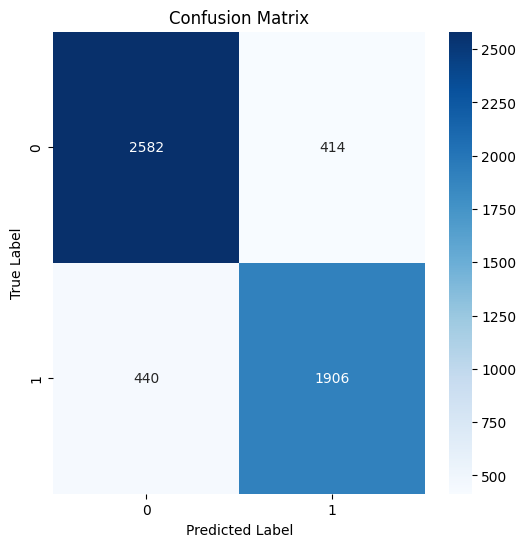

Classification Report for TensorFlow:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      2996
           1       0.82      0.81      0.82      2346

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



In [27]:
# Confusion Matrix for TensorFlow
cm = confusion_matrix(y_test, y_pred_tensorflow)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report for TensorFlow
report = classification_report(y_test, y_pred_tensorflow)
print("Classification Report for TensorFlow:\n", report)

In [28]:
# Plot Accuracy and Loss for TensorFlow
def plot_metrics(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')
    plt.show()

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8799 - loss: 0.2961 - val_accuracy: 0.8489 - val_loss: 0.3477
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9120 - loss: 0.2283 - val_accuracy: 0.8568 - val_loss: 0.3408
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9362 - loss: 0.1758 - val_accuracy: 0.8568 - val_loss: 0.3474
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9536 - loss: 0.1366 - val_accuracy: 0.8544 - val_loss: 0.3749
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.9540 - loss: 0.1317 - val_accuracy: 0.8540 - val_loss: 0.3833


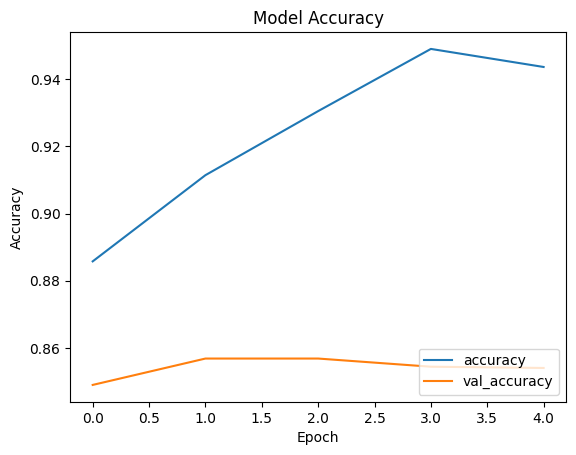

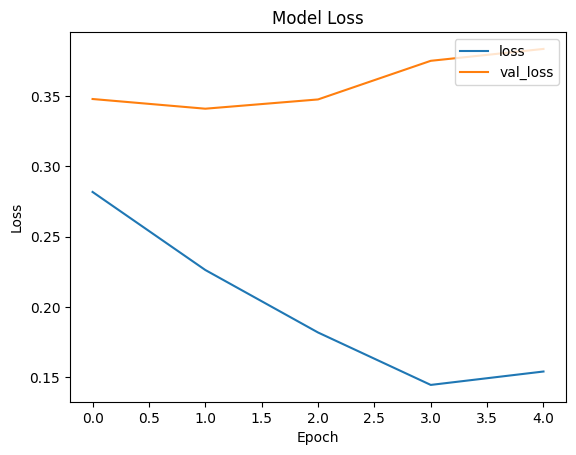

In [29]:
# Fit the TensorFlow model to plot the metrics
history = best_model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))

# Display plots
plot_metrics(history)

# **RNN Models untuk Deteksi Sarkasme**

Proyek ini bertujuan untuk membangun model deep learning menggunakan RNN (Recurrent Neural Networks) untuk mendeteksi sarkasme dalam teks. Dataset yang digunakan adalah DeteksiSarkasme.json, yang berisi kalimat yang diberi label apakah kalimat tersebut mengandung sarkasme atau tidak.

Model ini dibangun menggunakan dua framework deep learning yang berbeda, yaitu PyTorch dan TensorFlow, dengan menggunakan RNN layer untuk memproses data urutan teks. Proyek ini juga mencakup hyperparameter tuning dengan Keras Tuner untuk model TensorFlow dan evaluasi model menggunakan berbagai metrik performa.

### 1. **Tujuan Proyek**:
Proyek ini bertujuan untuk membangun dua model deep learning dengan RNN yang dapat mendeteksi apakah suatu kalimat mengandung sarkasme atau tidak. Model yang dibangun bertujuan untuk memaksimalkan akurasi dan keseimbangan antara presisi dan recall, serta memperbaiki kemampuan model dalam mendeteksi kelas positif (sarkasme).

### 2. **Langkah-langkah yang Diambil**:

#### a. **Praproses Data**:
Dataset DeteksiSarkasme.json memuat teks yang telah diberi label sarkasme (0 atau 1). Proses praproses dilakukan dengan:
- Menggunakan Tokenizer untuk mengonversi teks menjadi urutan numerik.
- Melakukan padding pada data untuk memastikan panjang input yang konsisten.

#### b. **Membangun Model RNN**:
Model RNN dibangun menggunakan dua framework:
- PyTorch: Model RNN dibangun menggunakan lapisan embedding untuk representasi kata, diikuti oleh lapisan RNN, dan akhirnya lapisan fully connected.
- TensorFlow: Model serupa juga dibangun di TensorFlow menggunakan SimpleRNN untuk menangani data berurutan.

#### c. **Hyperparameter Tuning**:
Untuk TensorFlow, dilakukan hyperparameter tuning menggunakan Keras Tuner untuk mencari kombinasi hyperparameter terbaik, seperti ukuran lapisan embedding, jumlah unit pada lapisan RNN, dan laju pembelajaran (learning rate).

#### d. **Evaluasi Model**:
Model dievaluasi menggunakan beberapa metrik kinerja berikut:
- Akurasi: Rasio prediksi yang benar.
- Presisi: Seberapa banyak prediksi positif yang benar-benar positif.
- Recall: Seberapa banyak kelas positif yang dapat terdeteksi oleh model.
- F1 Score: Kombinasi presisi dan recall yang memberikan gambaran keseimbangan antara keduanya.
- AUC (Area Under the Curve): Mengukur kemampuan model dalam membedakan antara kelas positif dan negatif.

#### e. **Visualisasi**:
Visualisasi dilakukan untuk menampilkan kurva akurasi dan loss selama pelatihan untuk kedua model. Ini membantu untuk memantau performa model dan memastikan bahwa model tidak mengalami overfitting.

### 3. **Hasil yang Diperoleh**:

- **Metrik untuk PyTorch**:
  - **Akurasi**: 0.8246
  - **Presisi**: 0.8510
  - **Recall**: 0.7280
  - **F1 Score**: 0.7847

- **Metrik untuk TensorFlow**:
  - **Akurasi**: 0.8540
  - **Presisi**: 0.8666
  - **Recall**: 0.7890
  - **F1 Score**: 0.8260
  - **AUC**: 0.8469

### 4. **Kesimpulan**:

- **TensorFlow** menunjukkan performa yang sedikit lebih baik dibandingkan dengan **PyTorch** di sebagian besar metrik evaluasi, terutama dalam Akurasi, Recall, F1 Score, dan AUC.
- Akurasi pada TensorFlow lebih tinggi, yang menunjukkan model lebih akurat dalam mengklasifikasikan data.
- Recall yang lebih tinggi pada TensorFlow menunjukkan bahwa model tersebut lebih baik dalam mendeteksi kelas positif (sarkasme).
- F1 Score yang lebih tinggi pada TensorFlow menunjukkan bahwa model memiliki keseimbangan yang lebih baik antara presisi dan recall.
- AUC yang lebih tinggi pada TensorFlow mengindikasikan bahwa model tersebut lebih unggul dalam memisahkan kelas positif dan negatif.

### Penjelasan untuk Setiap Metrik Matematika:

1. **Akurasi (Accuracy)**:
   - **Formula**:  
     
  $$\text{Akurasi} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$
     
   - **Penjelasan**: Akurasi mengukur persentase prediksi yang benar (baik untuk kelas positif maupun negatif) dibandingkan dengan total sampel yang diuji.
   
2. **Presisi (Precision)**:
   - **Formula**:
     
     $$\text{Presisi} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
     
   - **Penjelasan**: Presisi mengukur seberapa banyak dari prediksi positif yang benar-benar positif.
   
3. **Recall (Sensitivity atau True Positive Rate)**:
   - **Formula**:
     
     $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
     
   - **Penjelasan**: Recall mengukur seberapa banyak dari kelas positif yang sebenarnya berhasil dideteksi oleh model.

4. **F1 Score**:
   - **Formula**:
     
     $$F1 \, \text{Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}$$
     
   - **Penjelasan**: F1 Score adalah rata-rata harmonis antara Presisi dan Recall, yang memberikan gambaran tentang keseimbangan antara keduanya.

5. **AUC (Area Under the ROC Curve)**:
   - **Formula**: AUC mengukur area di bawah ROC curve, yang menggambarkan kemampuan model untuk membedakan antara kelas positif dan negatif.

### **5. Kesimpulan Akhir Proyek: RNN Models untuk Deteksi Sarkasme**

Proyek ini bertujuan untuk membangun dan mengevaluasi dua model RNN untuk deteksi sarkasme menggunakan dataset DeteksiSarkasme.json. Setelah melakukan eksperimen menggunakan PyTorch dan TensorFlow, berikut adalah kesimpulan dari hasil yang diperoleh:

- TensorFlow memberikan performa yang lebih baik dibandingkan PyTorch dalam semua metrik evaluasi (Akurasi, Presisi, Recall, F1 Score, AUC). Model TensorFlow menunjukkan Akurasi sebesar 85.40%, sedangkan PyTorch hanya 82.46%.
- TensorFlow juga unggul dalam Precision (86.66% vs 85.10%) dan Recall (78.90% vs 72.80%), yang menunjukkan bahwa model TensorFlow lebih efektif dalam mendeteksi sarkasme tanpa menghasilkan terlalu banyak prediksi salah.
- Dengan F1 Score 82.60% dan AUC 84.69%, TensorFlow lebih seimbang dalam mengelola trade-off antara presisi dan recall serta lebih baik dalam membedakan antara kelas positif dan negatif.

Secara keseluruhan, TensorFlow menunjukkan kinerja yang lebih unggul dalam mendeteksi sarkasme, namun kedua model (PyTorch dan TensorFlow) memberikan hasil yang baik dalam tugas ini.
